In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import IPython

from preprocessing import get_spectrogram
from preprocessing import get_audio_and_label

from sklearn.model_selection import ParameterGrid

from glob import glob
from time import time
import os
import csv

2023-03-02 14:05:53.313268: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 14:05:53.439397: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-02 14:05:53.444520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 14:05:53.444543: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
# Comment the following line after the first run
# !unzip -q /work/Mini-CREMA.zip

In [3]:
!ls Mini-CREMA/ | wc -l

3


In [4]:
!ls Mini-CREMA/ | head -n5

test
train
val


In [5]:
filename = 'Mini-CREMA/test/1002_IOM_ANG_XX.wav'

In [6]:
audio_binary = tf.io.read_file(filename)
audio, sampling_rate = tf.audio.decode_wav(audio_binary)


path_parts = tf.strings.split(filename, '/')
# print(path_parts)
path_end = path_parts[-1]
# print(path_end)
file_parts = tf.strings.split(path_end, '_')
label = file_parts[-2]


print('Label:', label.numpy().decode())
print('Audio shape:', audio.shape)
print('Sampling rate:', sampling_rate)

IPython.display.Audio(filename=filename, rate=sampling_rate)

Label: ANG
Audio shape: (45379, 1)
Sampling rate: tf.Tensor(16000, shape=(), dtype=int32)
2023-03-02 14:05:56.391058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-02 14:05:56.391091: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-02 14:05:56.391113: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-bbbdb20a-e3ad-45ae-ada8-c5509dba9cda): /proc/driver/nvidia/version does not exist
2023-03-02 14:05:56.391465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [7]:
audio_8k = tfio.audio.resample(audio, sampling_rate.numpy(), 8000)

print('Resampled Audio shape:', audio_8k.shape) #this cut in half the dimension of the audio file


2023-03-02 14:05:56.569428: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2023-03-02 14:05:56.569646: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 AVX512F FMA
Resampled Audio shape: (22689, 1)


### We have to understand how to capture the majority of audio and have all the files equal

reference min 28 https://www.youtube.com/watch?v=ZLIPkmmDJAc&t=1245s

When training a deep neural network for audio classification, it is usually better to take shorter segments of the full audio rather than resampling the entire audio to a lower sampling rate.

There are several reasons for this:

Memory and computational requirements: Deep neural networks require a large amount of memory and computational resources to train. By taking shorter segments of the full audio, you can reduce the amount of memory and computation required, allowing you to train larger models and perform more experiments in less time.

Training data diversity: By taking shorter segments of the full audio, you can increase the diversity of the training data. This is because different segments of the same audio may have different characteristics, such as the presence or absence of certain sounds or noise. By including multiple segments of the same audio in the training data, you can improve the generalization performance of the model.

Real-time processing: In many applications, such as speech recognition or audio surveillance, the audio data is processed in real time. By taking shorter segments of the full audio, you can process the audio in real time, rather than waiting for the entire audio to be processed before making a prediction.

That being said, the choice of segment length depends on the specific task and the characteristics of the audio data. In general, segment lengths of 1-10 seconds are common for audio classification tasks   chatgpt <3

In [8]:
dir1 = 'Mini-CREMA/train'
dir2 = 'Mini-CREMA/test'
dir3 = 'Mini-CREMA/val'

file_list = []

for directory in [dir1, dir2, dir3]:
    for filename in os.listdir(directory):
        file_list.append(os.path.join(directory, filename))

print(len(file_list))

3629


In [9]:
lengths = []
sampling_freq_set = set()
max_audio = 0
name_max_audio = ''
min_audio = 100000000000
name_min_audio = ''

for file_name in file_list:
    audio_binary = tf.io.read_file(file_name)
    audio, sampling_rate = tf.audio.decode_wav(audio_binary)
    lengths.append(audio.shape[0])
    if(audio.shape[0]>max_audio):
        max_audio = audio.shape[0]
        name_max_audio = file_name

    if(audio.shape[0]<min_audio):
        min_audio = audio.shape[0]
        name_min_audio = file_name

    sampling_freq_set.add(sampling_rate.numpy())

print(len(lengths))
print(sampling_freq_set)

3629
{16000}


In [10]:
print(f'Max audio name is {name_max_audio} and has length {max_audio}')
IPython.display.Audio(filename=name_max_audio, rate=sampling_rate)

Max audio name is Mini-CREMA/test/1008_TIE_ANG_XX.wav and has length 79546


In [11]:
print(f'Min audio name is {name_min_audio} and has length {min_audio}')
IPython.display.Audio(filename=name_min_audio, rate=sampling_rate)

Min audio name is Mini-CREMA/train/1075_IEO_HAP_HI.wav and has length 21355


In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=39255>

In [13]:
print("The average length of audios is:")
print(39255/16000)

The average length of audios is:
2.4534375


In [14]:
print("The min and max of audios are:")
print(tf.math.reduce_min(lengths))
print('the min length in seconds is: ', 21355/16000)
print(tf.math.reduce_max(lengths))
print('the max length in seconds is: ', 79546/16000)

The min and max of audios are:
tf.Tensor(21355, shape=(), dtype=int32)
the min length in seconds is:  1.3346875
tf.Tensor(79546, shape=(), dtype=int32)
the max length in seconds is:  4.971625


In [15]:
def get_audio_and_label(filename):
    sample_points = 48000
    audio_binary = tf.io.read_file(filename)
    audio, sampling_rate = tf.audio.decode_wav(audio_binary) 

    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    label = file_parts[-2]
    
    audio = tf.squeeze(audio)
    audio = audio[:sample_points]
    #print(audio.shape)
    zero_padding = tf.zeros(sample_points - tf.shape(audio), dtype=tf.float32)
    audio_padded = tf.concat([audio, zero_padding], axis=0)
    audio = audio_padded

    return audio, sampling_rate, label

In [16]:
filename = 'Mini-CREMA/test/1002_IOM_ANG_XX.wav'
# longest audio clip Mini-CREMA/test/1008_TIE_ANG_XX.wav also works
audio, sampling_rate, label = get_audio_and_label(filename)
audio,sampling_rate, label

(<tf.Tensor: shape=(48000,), dtype=float32, numpy=
 array([-2.7465820e-04,  3.0517578e-05,  5.1879883e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=16000>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ANG'>)

In [17]:
plt.hist(lengths, bins=50)
plt.title("Distribution of data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


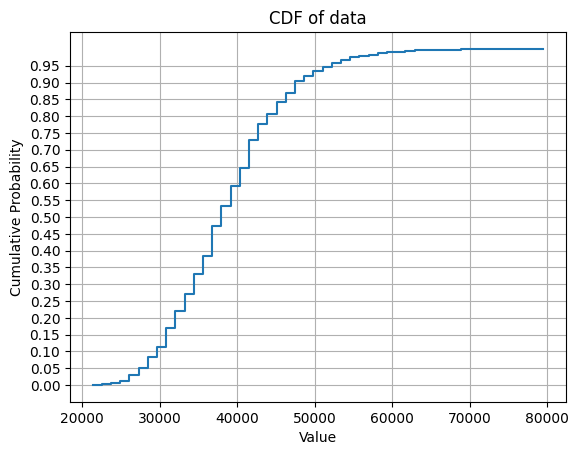

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

data =lengths

ecdf = ECDF(data)
x = np.linspace(min(data), max(data))
y = ecdf(x)

plt.step(x, y)
plt.title("CDF of data")
plt.xlabel("Value")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.yticks(np.arange(0, 1, 0.05))
plt.show()

In [19]:
from visualization import visualize_features

In [20]:
#HAP
visualize_features('/work/Mini-CREMA/train/1002_ITS_HAP_XX.wav', 16000, 0.04, 0.02, 40, 20, 4000, 10)

(38972,)
(38972,)
(38972,)
(38972,)


(40040,)
(40040,)
(40040,)
(40040,)


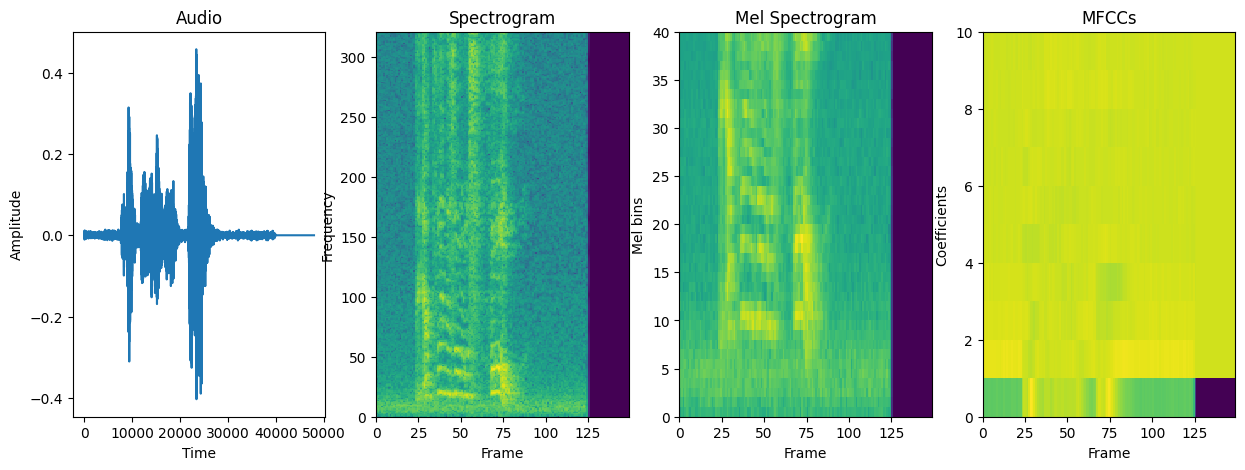

In [21]:
#ANG
visualize_features('/work/Mini-CREMA/train/1002_TAI_ANG_XX.wav', 16000, 0.04, 0.02, 40, 20, 4000, 10)

(48000,)
(48000,)
(48000,)
(48000,)


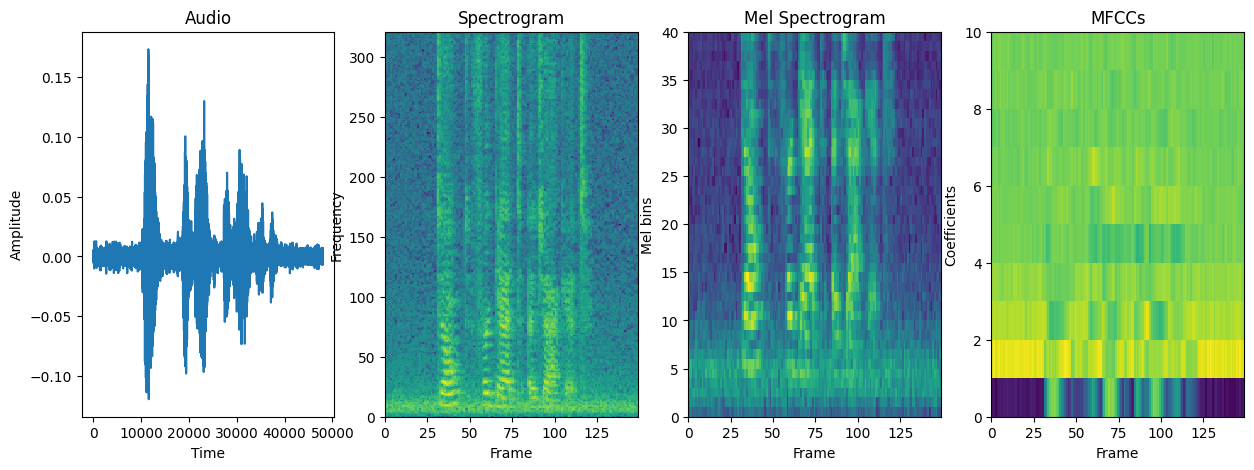

In [22]:
#NEU
visualize_features('/work/Mini-CREMA/train/1003_DFA_NEU_XX.wav', 16000, 0.04, 0.02, 40, 20, 4000, 10)

In [23]:
count_files_hap=0
count_files_ang=0
count_files_neu=0
files_authors = {}


for filename in file_list:
    audio, sampling_rate, label = get_audio_and_label(filename)
    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    author = str(file_parts[-4])
    
    if label == 'HAP':
        count_files_hap += 1
        if author not in files_authors:
            files_authors[author] = [1, 0, 0]
        else:
            files_authors[author][0] += 1
    elif label == 'ANG':
        count_files_ang += 1
        if author not in files_authors:
            files_authors[author] = [0, 1, 0]
        else:
             files_authors[author][1] += 1
    elif label == 'NEU':
        count_files_neu += 1
        if author not in files_authors:
            files_authors[author] = [0, 0, 1]
        else:
            files_authors[author][2] += 1

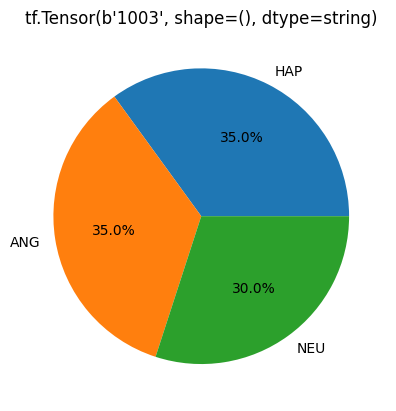

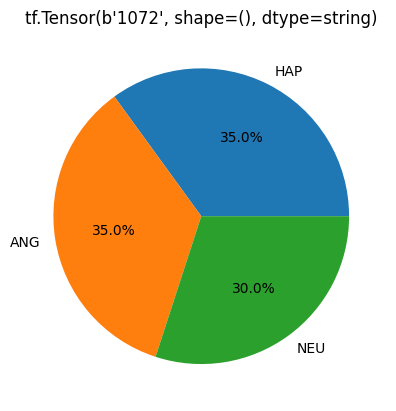

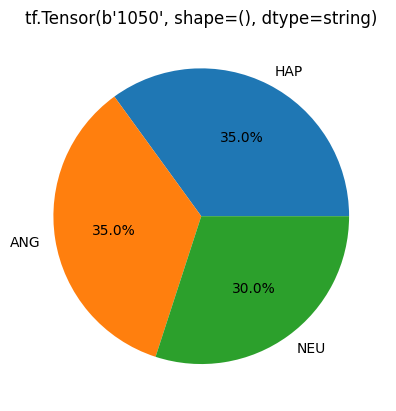

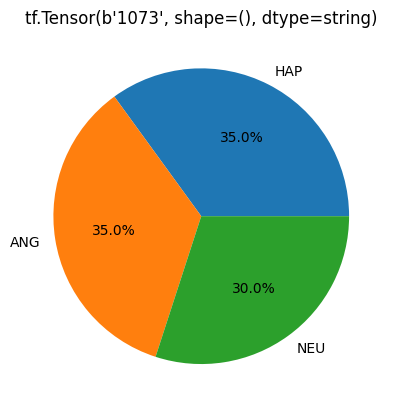

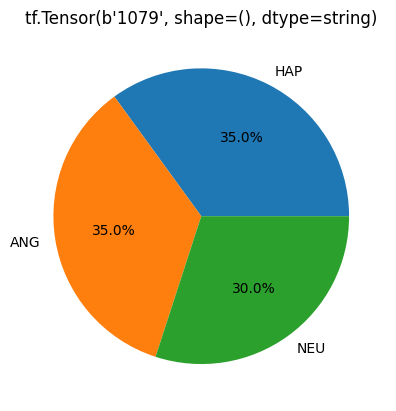

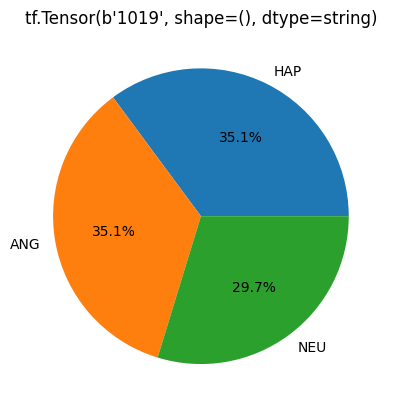

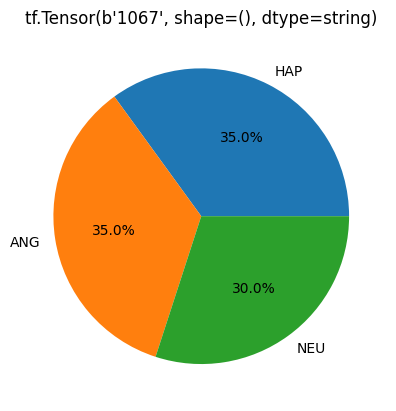

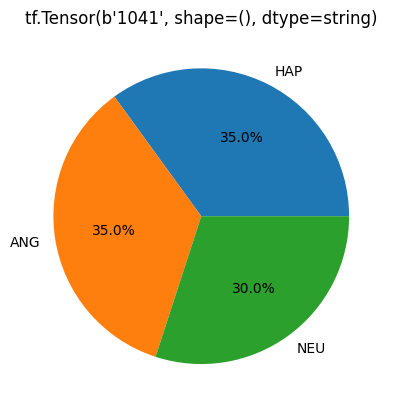

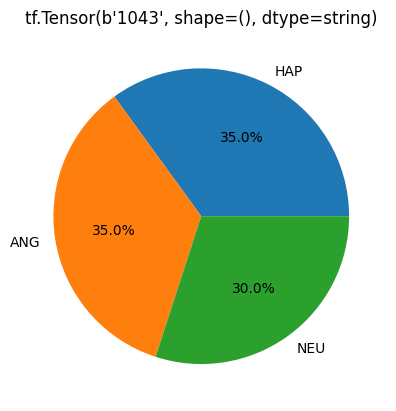

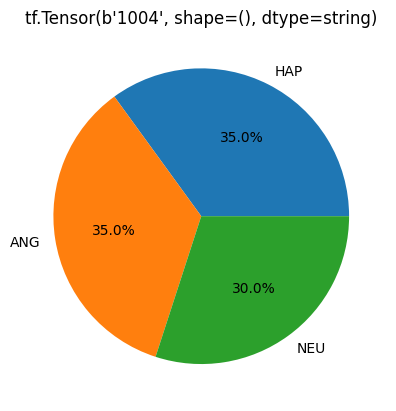

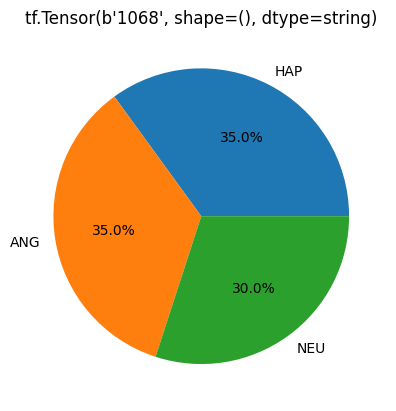

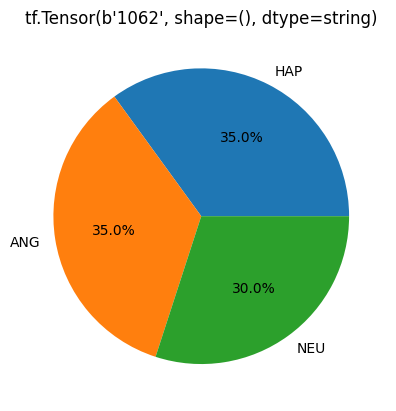

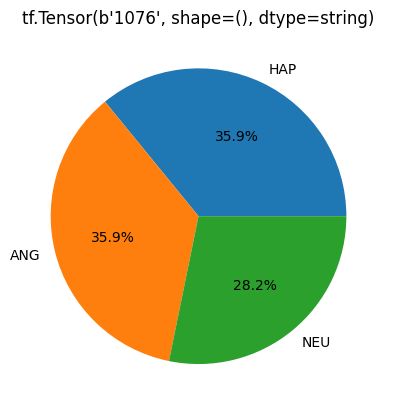

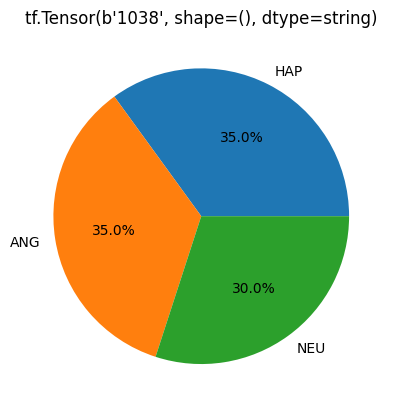

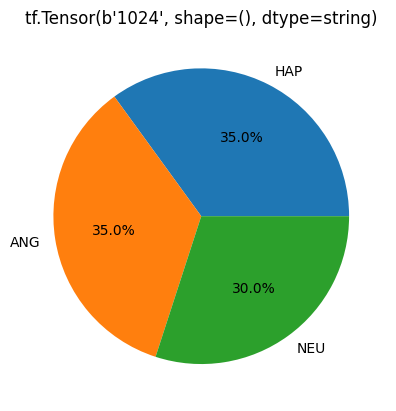

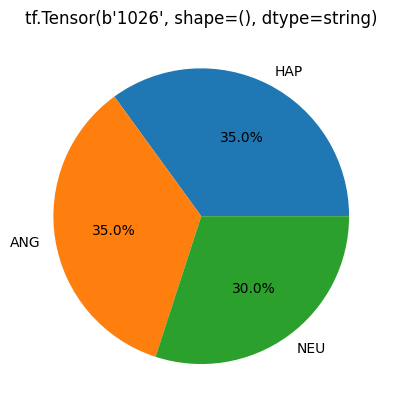

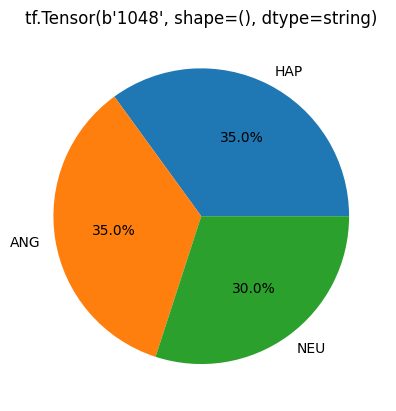

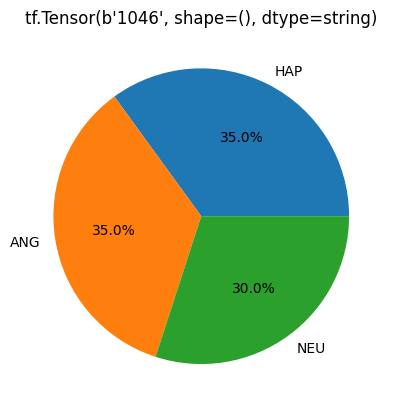

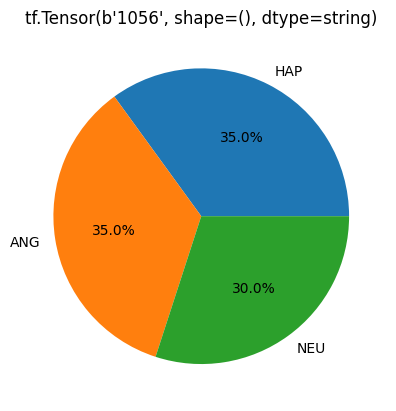

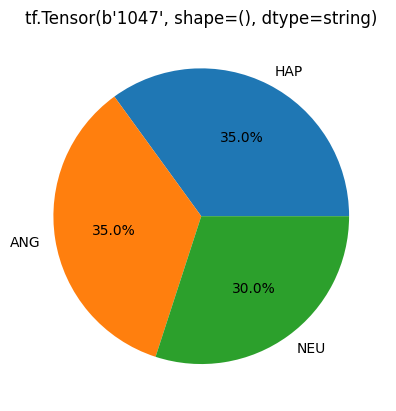

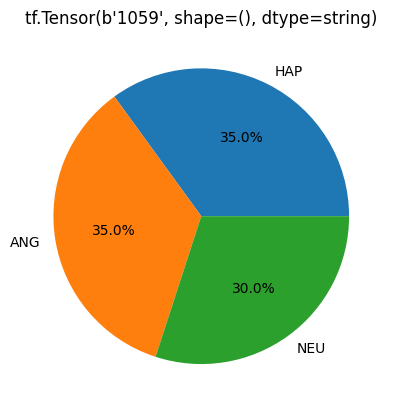

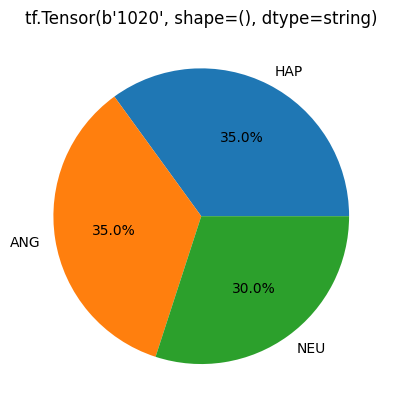

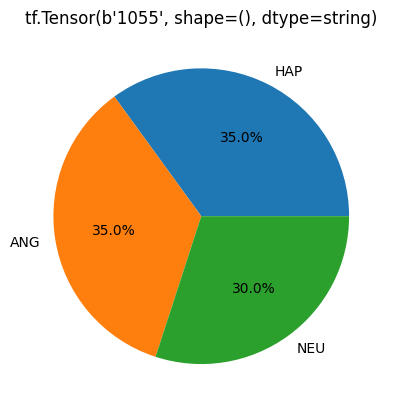

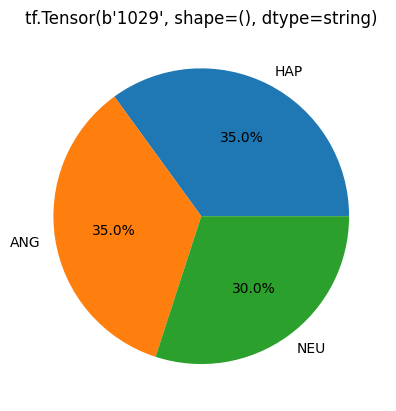

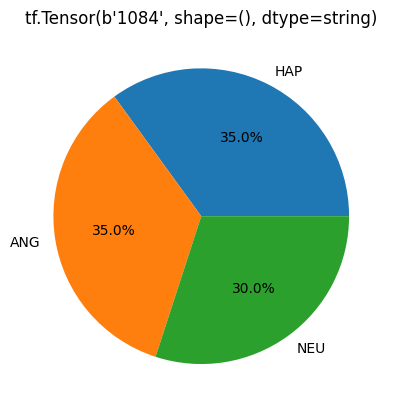

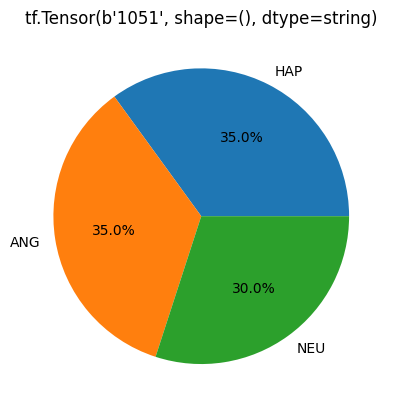

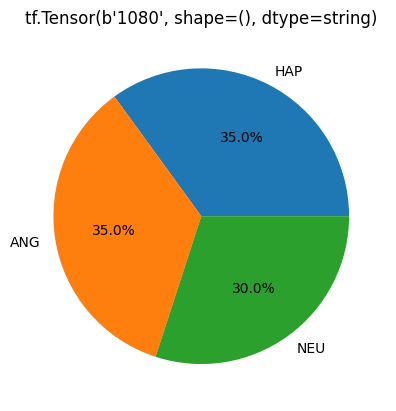

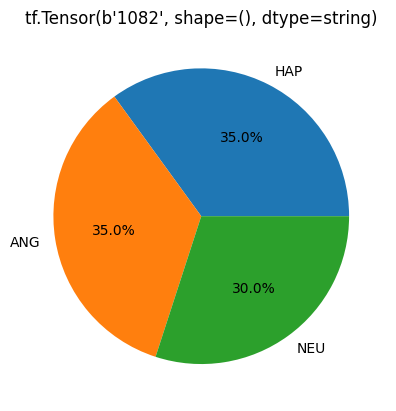

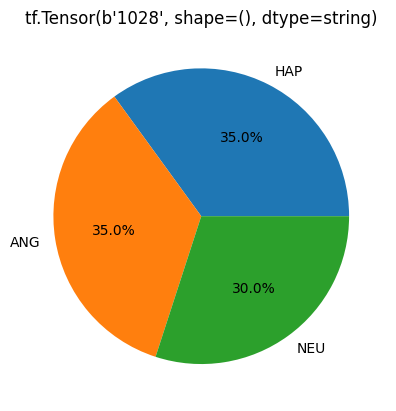

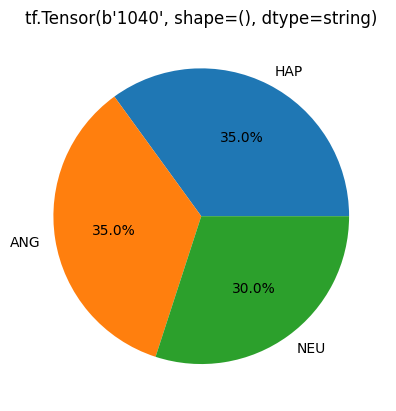

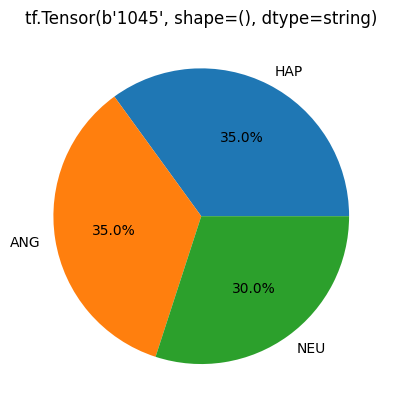

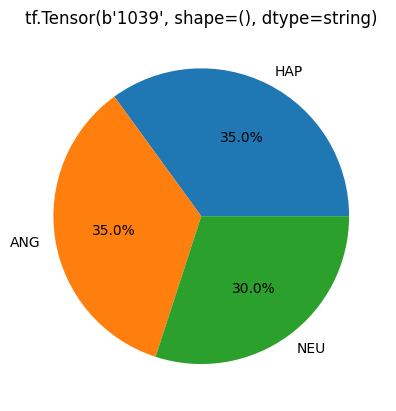

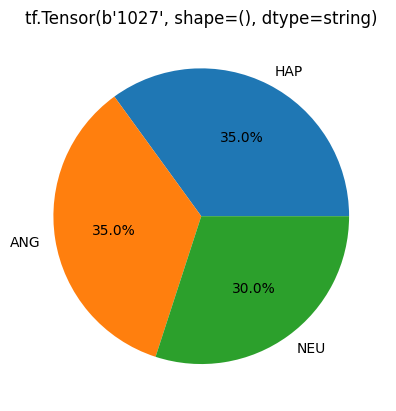

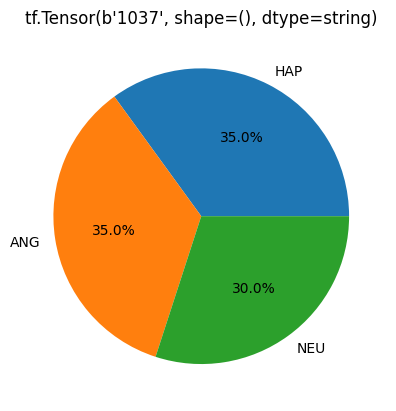

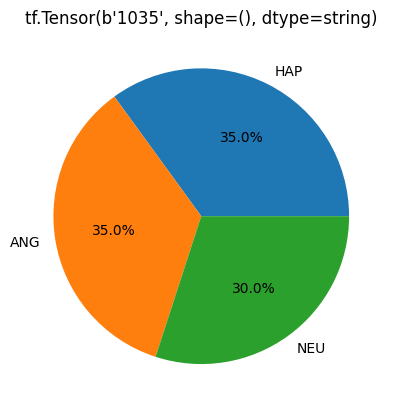

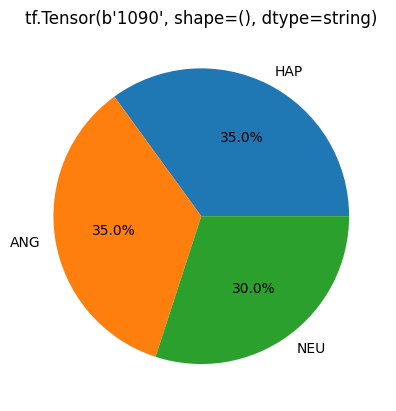

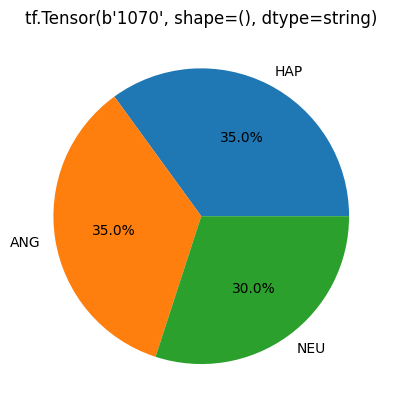

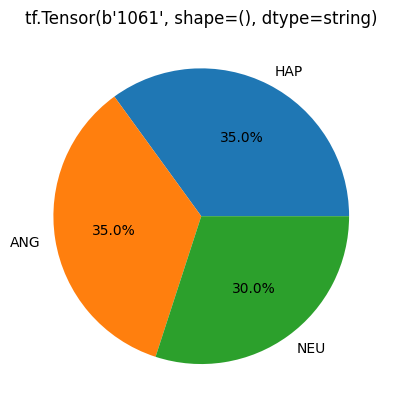

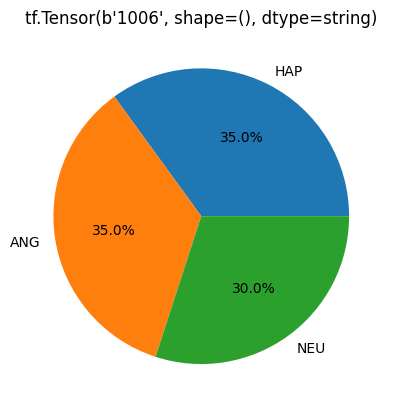

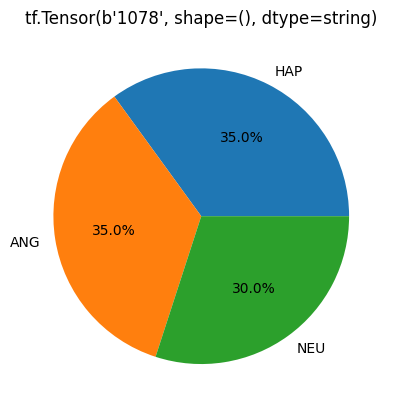

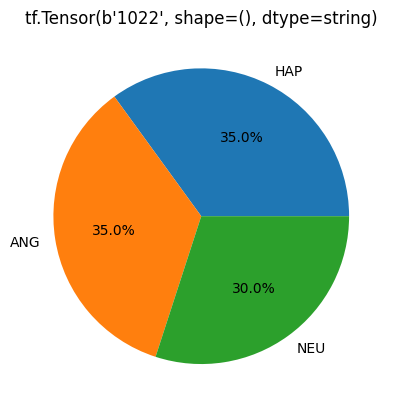

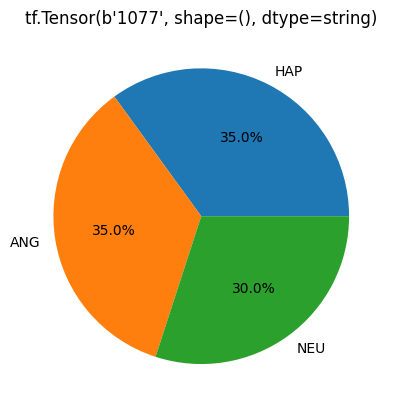

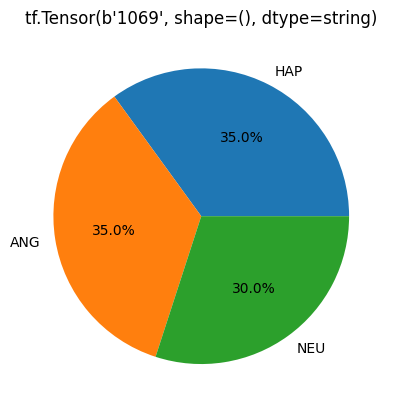

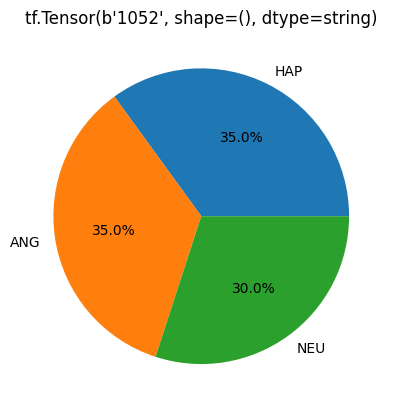

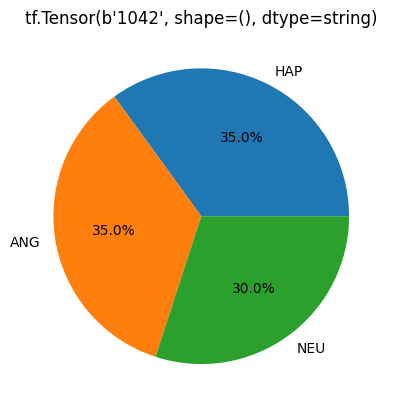

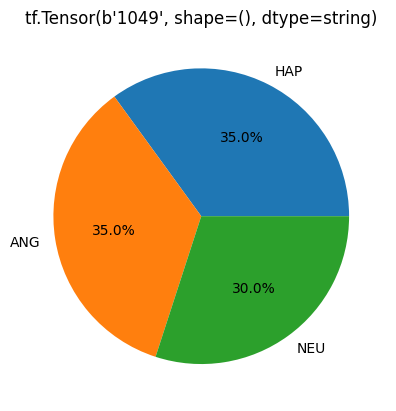

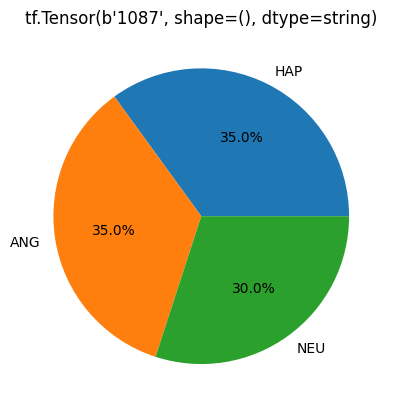

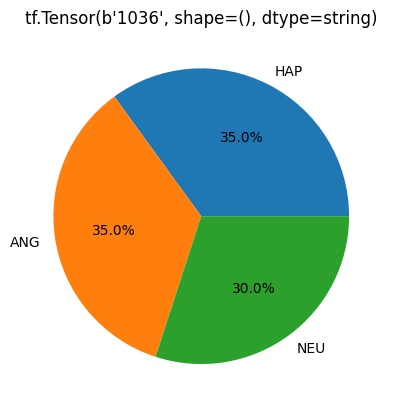

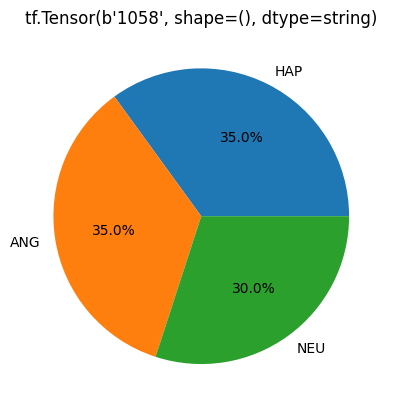

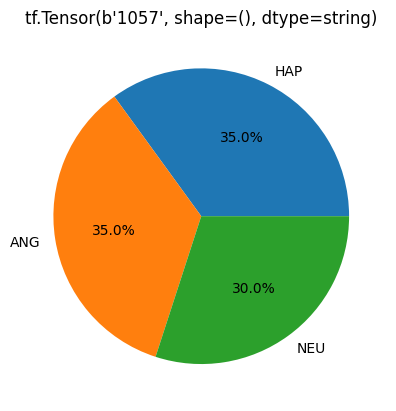

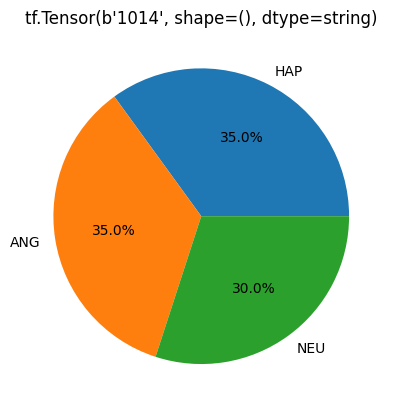

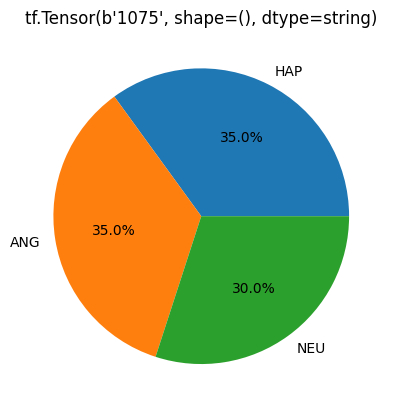

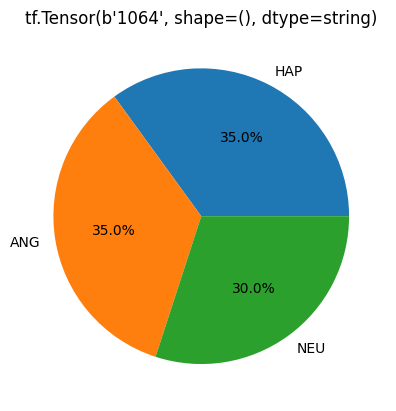

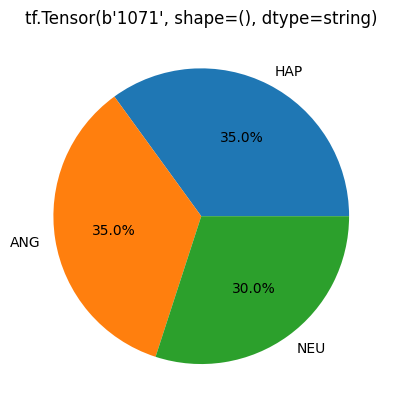

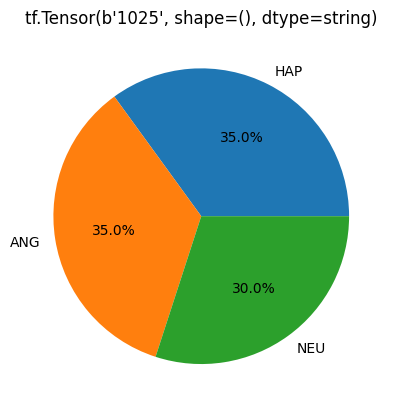

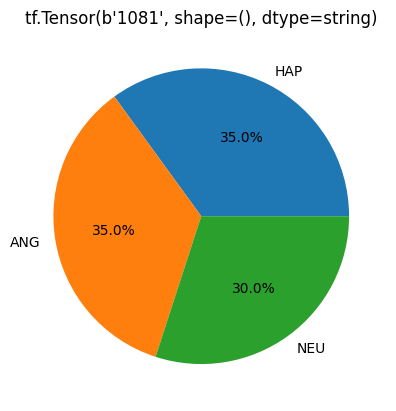

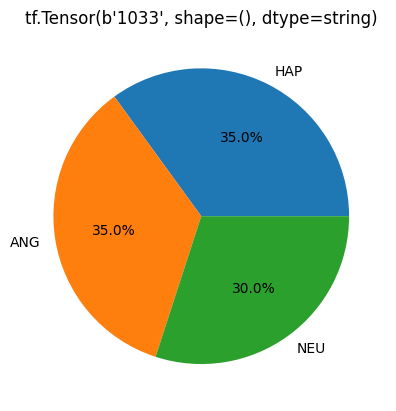

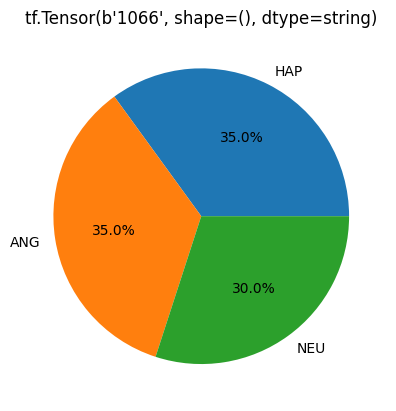

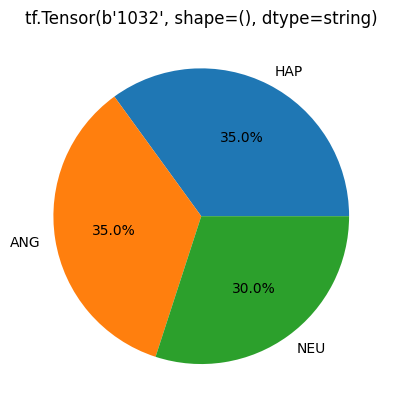

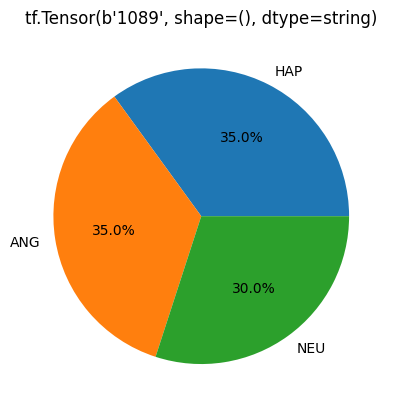

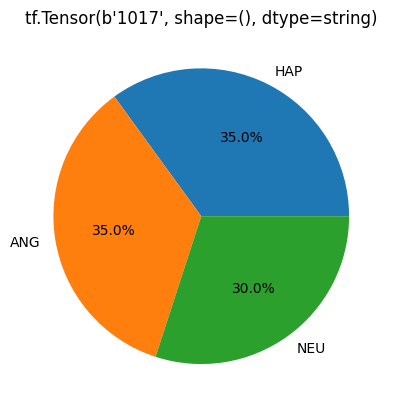

In [24]:
for key in files_authors.keys():
    counts = files_authors[key]
    categories = ['HAP', 'ANG', 'NEU']
    plt.pie(counts, labels=categories, autopct='%1.1f%%')
    plt.title(key)
    plt.show()
    

In [25]:
number_authors = (len(files_authors.keys()))
print("Number of authors: ", number_authors)

Number of authors:  91


In [26]:
print("Number of happy audio: ", count_files_hap)
print("Number of anger audio: ", count_files_ang)
print("Number of neutral audio: ", count_files_neu)

Number of happy audio:  1271
Number of anger audio:  1271
Number of neutral audio:  1087


In [27]:
files_sentences = {}


for filename in file_list:
    audio, sampling_rate, label = get_audio_and_label(filename)
    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    sentence = str(file_parts[-3])
    
    if label == 'HAP':
       
        if sentence not in files_sentences:
            files_sentences[sentence] = [1, 0, 0]
        else:
            files_sentences[sentence][0] += 1
    elif label == 'ANG':
        
        if sentence not in files_sentences:
            files_sentences[sentence] = [0, 1, 0]
        else:
             files_sentences[sentence][1] += 1
    elif label == 'NEU':
        
        if sentence not in files_sentences:
            files_sentences[sentence] = [0, 0, 1]
        else:
            files_sentences[sentence][2] += 1

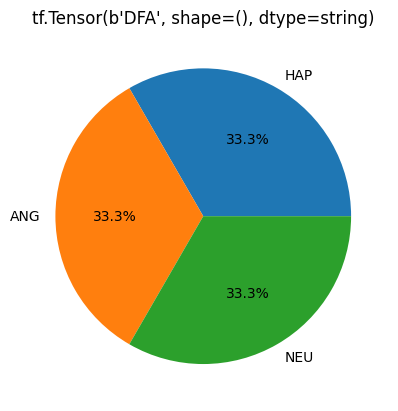

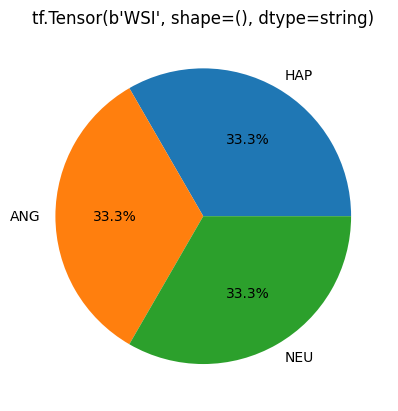

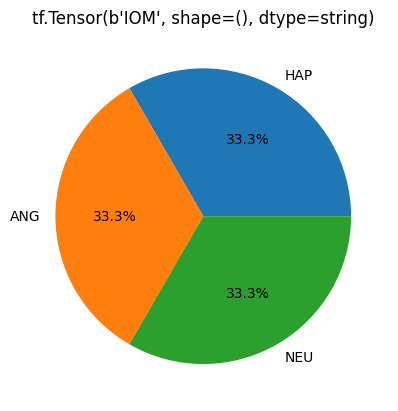

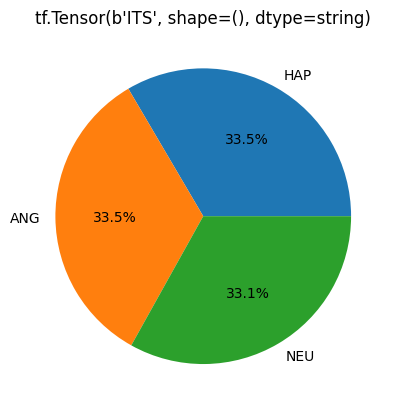

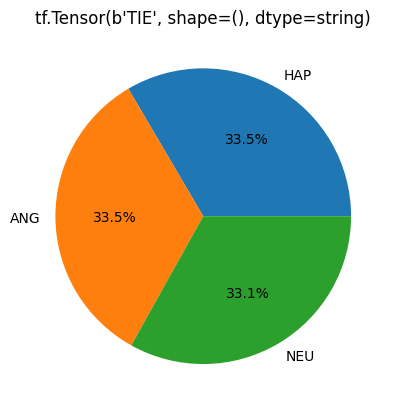

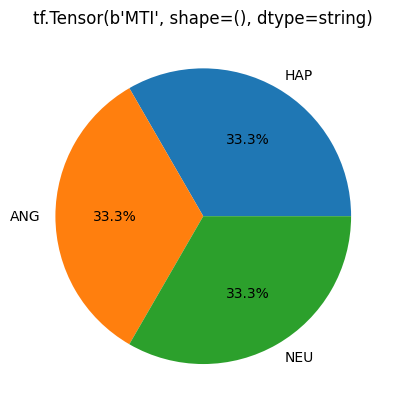

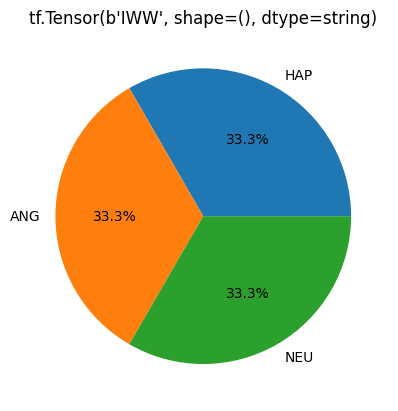

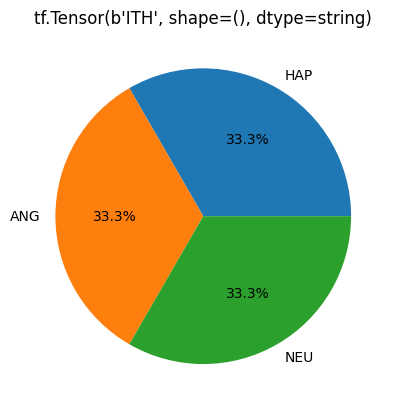

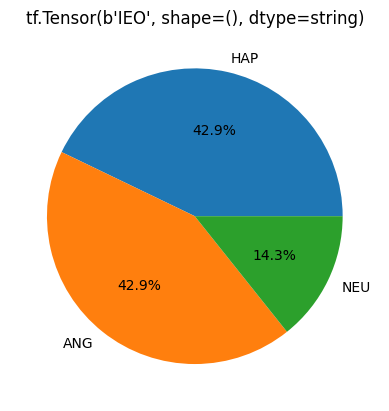

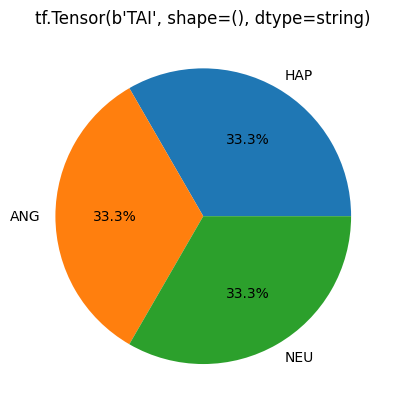

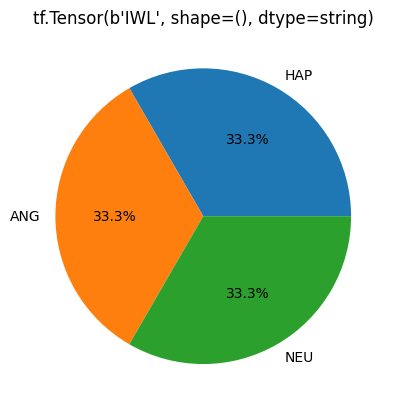

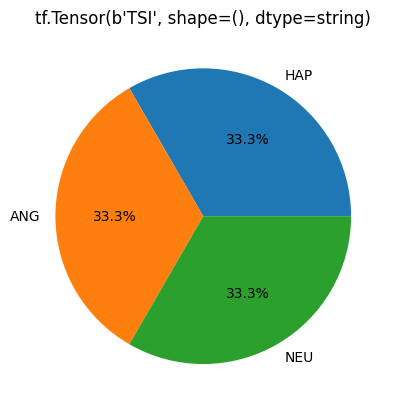

In [28]:
for key in files_sentences.keys():
    counts = files_sentences[key]
    categories = ['HAP', 'ANG', 'NEU']
    plt.pie(counts, labels=categories, autopct='%1.1f%%')
    plt.title(key)
    plt.show()

In [53]:
files_happy = []
files_anger = []
files_neutral = []

for filename in file_list:
    audio, sampling_rate, label = get_audio_and_label(filename)
    path_parts = tf.strings.split(filename, '/')
    # print(path_parts)
    path_end = path_parts[-1]
    # print(path_end)
    file_parts = tf.strings.split(path_end, '_')
    author = str(file_parts[-4])
    
    if label == 'HAP':
        
            files_happy.append(filename)
    if label == 'ANG':
        
            files_anger.append(filename)
    if label == 'NEU':
        
            files_neutral.append(filename)
        

In [54]:
print(files_happy)

['Mini-CREMA/train/1007_TIE_HAP_XX.wav', 'Mini-CREMA/train/1073_MTI_HAP_XX.wav', 'Mini-CREMA/train/1019_TIE_HAP_XX.wav', 'Mini-CREMA/train/1065_ITH_HAP_XX.wav', 'Mini-CREMA/train/1009_IEO_HAP_HI.wav', 'Mini-CREMA/train/1012_WSI_HAP_XX.wav', 'Mini-CREMA/train/1041_ITS_HAP_XX.wav', 'Mini-CREMA/train/1013_TAI_HAP_XX.wav', 'Mini-CREMA/train/1004_IEO_HAP_MD.wav', 'Mini-CREMA/train/1068_IWW_HAP_XX.wav', 'Mini-CREMA/train/1076_IWW_HAP_XX.wav', 'Mini-CREMA/train/1038_ITH_HAP_XX.wav', 'Mini-CREMA/train/1030_MTI_HAP_XX.wav', 'Mini-CREMA/train/1026_ITH_HAP_XX.wav', 'Mini-CREMA/train/1091_IWW_HAP_XX.wav', 'Mini-CREMA/train/1011_IWL_HAP_XX.wav', 'Mini-CREMA/train/1020_DFA_HAP_XX.wav', 'Mini-CREMA/train/1059_IEO_HAP_MD.wav', 'Mini-CREMA/train/1084_DFA_HAP_XX.wav', 'Mini-CREMA/train/1051_WSI_HAP_XX.wav', 'Mini-CREMA/train/1002_ITS_HAP_XX.wav', 'Mini-CREMA/train/1082_ITH_HAP_XX.wav', 'Mini-CREMA/train/1073_IEO_HAP_LO.wav', 'Mini-CREMA/train/1056_TSI_HAP_XX.wav', 'Mini-CREMA/train/1048_TSI_HAP_XX.wav',

In [55]:
import wave
import numpy as np

def compute_average_spectrogram(file_list):
    # Inizializza una variabile per contenere tutti gli spettri
    all_specs = []

    for file_name in file_list:
        # Apri il file WAV
        with wave.open(file_name, 'rb') as wave_file:
            # Leggi i parametri del file
            sample_rate = wave_file.getframerate()
            num_samples = wave_file.getnframes()

            # Leggi i dati del file
            wave_data = wave_file.readframes(num_samples)

        # Converti i dati in un array NumPy a 16 bit
        wave_array = np.frombuffer(wave_data, dtype='int16')

        # Calcola lo spettrogramma del segnale audio
        spec, _, _ = np.histogram2d(np.arange(len(wave_array)), wave_array, bins=[512, 256], range=[[0, len(wave_array)], [-32768, 32767]])

        # Aggiungi lo spettro alla lista di tutti gli spettri
        all_specs.append(spec)

    # Calcola la media degli spettri
    avg_spec = np.mean(all_specs, axis=0)

    return avg_spec


In [60]:
def getAvgSpectrogram(file_list):
    avg = compute_average_spectrogram(file_list)
    # Visualizza lo spettrogramma medio come immagine
    plt.imshow(avg, origin='lower', cmap='jet', aspect='auto')

    # Aggiunge un'etichetta all'asse x
    plt.xlabel('Time (bins)')

    # Aggiunge un'etichetta all'asse y
    plt.ylabel('Frequency (bins)')

    # Aggiunge un titolo al grafico
    plt.title('Average Spectrogram')

    # Visualizza il grafico
    plt.show()

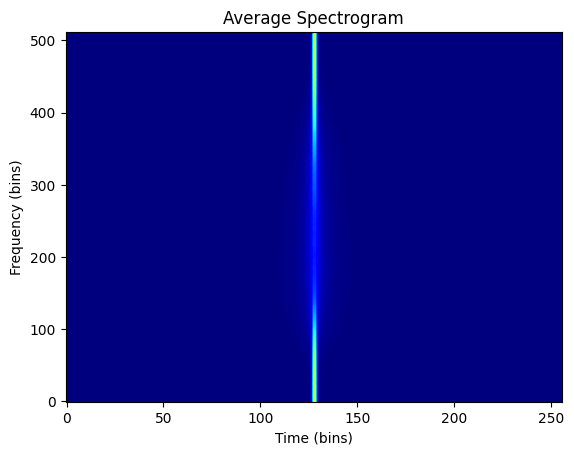

In [61]:
getAvgSpectrogram(files_happy)

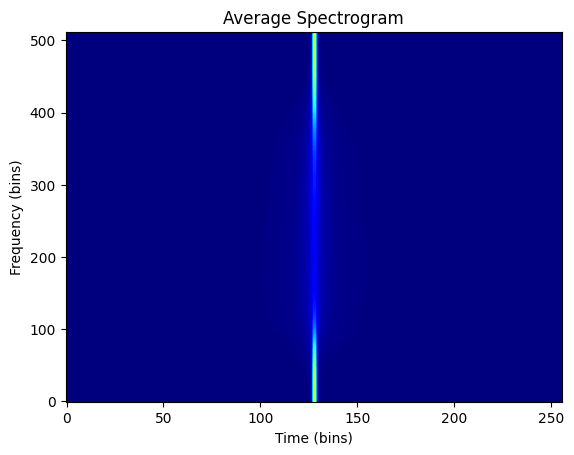

In [62]:
getAvgSpectrogram(files_anger)

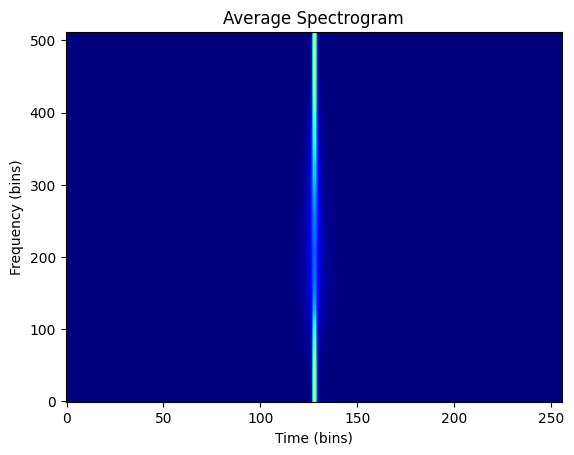

In [63]:
getAvgSpectrogram(files_neutral)

In [66]:
from mpl_toolkits.mplot3d import Axes3D
def getAvgSpectrogram3D(files_list):
    # Calcola lo spettrogramma medio
    avg_spec = compute_average_spectrogram(files_list)

    # Crea una figura
    fig = plt.figure()

    # Crea un'area di disegno tridimensionale
    ax = fig.add_subplot(111, projection='3d')

    # Genera un'array di coordinate x e y
    x, y = range(avg_spec.shape[1]), range(avg_spec.shape[0])
    X, Y = np.meshgrid(x, y)

    # Disegna la superficie
    surf = ax.plot_surface(X, Y, avg_spec, cmap='jet')

    # Aggiunge un'etichetta all'asse x
    ax.set_xlabel('Time (bins)')

    # Aggiunge un'etichetta all'asse y
    ax.set_ylabel('Frequency (bins)')

    # Aggiunge un'etichetta all'asse z
    ax.set_zlabel('Amplitude')

    # Aggiunge un titolo al grafico
    ax.set_title('Average Spectrogram')

    # Aggiunge una barra dei colori
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Visualizza il grafico
    plt.show()

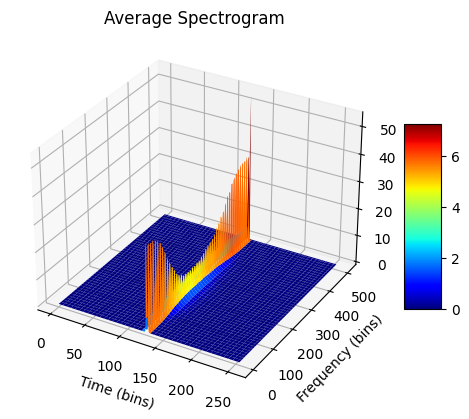

In [67]:
getAvgSpectrogram3D(files_happy)

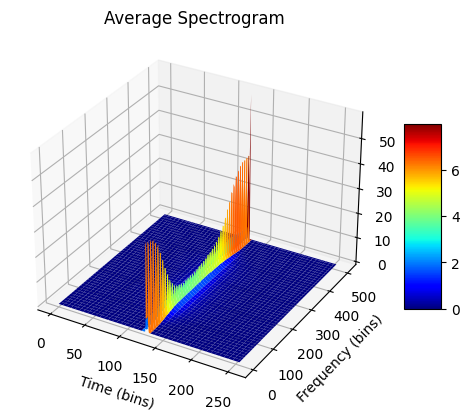

In [68]:
getAvgSpectrogram3D(files_anger)

In [69]:
getAvgSpectrogram3D(files_neutral)

In [78]:
def getAvgSpectrogram2D(file_list):
    # Calcola lo spettrogramma medio
    avg_spec = compute_average_spectrogram(file_list)

    # Crea un grafico a contorni
    plt.contourf(avg_spec.T, cmap='jet')

    # Aggiunge un'etichetta all'asse x
    plt.xlabel('Time (bins)')

    # Aggiunge un'etichetta all'asse y
    plt.ylabel('Frequency (bins)')
    
    # Aggiunge un titolo al grafico
    plt.title('Average Spectrogram')

    # Aggiunge una barra dei colori
    plt.colorbar()

    # Visualizza il grafico
    plt.show()

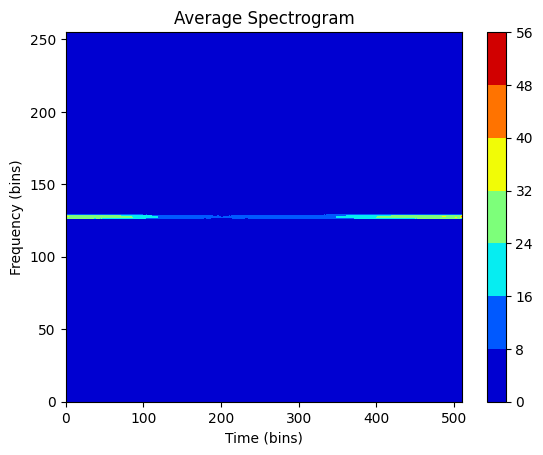

In [79]:
getAvgSpectrogram2D(files_happy)

In [80]:
getAvgSpectrogram2D(files_anger)

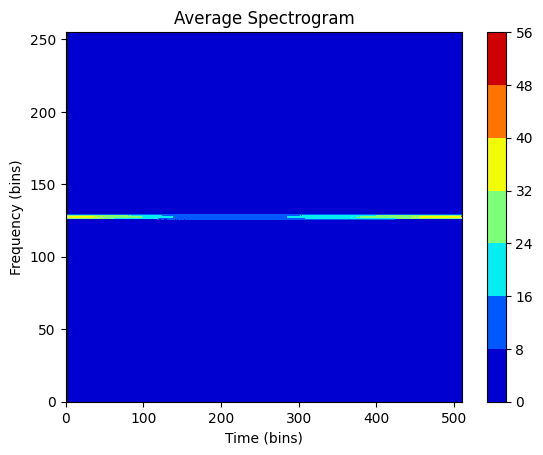

In [81]:
getAvgSpectrogram2D(files_neutral)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bbbdb20a-e3ad-45ae-ada8-c5509dba9cda' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>